In [8]:
import math
from copy import deepcopy
import random
import chess
from ChessWrapper import ChessWrapper
import time
import signal
import chess.pgn
from material_values import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cython

In [9]:
from stockfish import Stockfish
sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')

In [12]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [34]:
# better moves higher values
def move_value(board, move) -> float:
    if move.promotion is not None:
        return float("inf")

    _piece = board.piece_at(move.from_square)

    # endgame if neither side has a queen
    endgame = True if (board.pieces(chess.QUEEN, chess.BLACK) == 0 and board.pieces(chess.QUEEN, chess.WHITE) == 0) else False
        
    if _piece:
        _from_value = evaluate_piece(_piece, move.from_square, endgame)
        _to_value = evaluate_piece(_piece, move.to_square, endgame)
        position_change = _to_value - _from_value
    else:
        raise Exception(f"A piece was expected at {move.from_square}")

    capture_value = 0.0
    if board.is_capture(move):
        capture_value = evaluate_capture(board, move)

    check_value = 0.0
    if board.gives_check(move):
        check_value = 50.0

    current_move_value = capture_value + position_change + check_value

    return current_move_value

In [35]:
def evaluate_capture(board: chess.Board, move: chess.Move) -> float:
    """
    Given a capturing move, weight the trade being made.
    """
    if board.is_en_passant(move):
        return BASE_VALUES[chess.PAWN]
    _to = board.piece_at(move.to_square)
    _from = board.piece_at(move.from_square)
    if _to is None or _from is None:
        raise Exception(
            f"Pieces were expected at _both_ {move.to_square} and {move.from_square}"
        )
    return BASE_VALUES[_to.piece_type] - BASE_VALUES[_from.piece_type]

def evaluate_piece(piece, square, endgame):
    if piece.color == chess.WHITE:
        if endgame:
            return EG_MAP[piece.piece_type][56 ^ square]

        return MG_MAP[piece.piece_type][56 ^ square]
    else:
        if endgame:
            return EG_MAP[piece.piece_type][square]
        
        return MG_MAP[piece.piece_type][square]

In [36]:
def get_ordered_moves(board, moves):
    """
    Get legal moves.
    Attempt to sort moves by best to worst.
    Use piece values (and positional gains/losses) to weight captures.
    """
    def orderer(move):
        return move_value(board, move)

    in_order = sorted(
        moves, key=orderer, reverse=True
    )
    return list(in_order)


In [37]:
def alphabeta(depth, board, alpha, beta, is_max, lin_reg_eval):
    if board.is_checkmate():
        return -24000 if is_max else 24000 # TODO: no magic variable pls

    # game is over but not checkmate, so it's a draw
    elif board.is_game_over():
        return 0

    if depth <= 0:
        #return board.eval()
        return qsearch(6, board, alpha, beta, is_max, lin_reg_eval)

    if is_max:
        best_val = float('-inf')
        moves = get_ordered_moves(board, board.get_legal_moves())
        
        
        for move in moves:
                
            board.push(move)
            v = alphabeta(depth - 1, board, alpha, beta, not is_max, lin_reg_eval)

            if v > 23000:
                v -= 1
            elif v < -23000:
                v += 1
                
            best_val = max(best_val, v)
            alpha = max(alpha, best_val)
            board.pop()
            if beta <= alpha:
                break
        return best_val
    else:
        best_val = float('+inf')
        moves = get_ordered_moves(board, board.get_legal_moves())
        for move in moves:
            board.push(move)
            v = alphabeta(depth - 1, board, alpha, beta, not is_max, lin_reg_eval)
            if v > 23000:
                v -= 1
            elif v < -23000:
                v += 1
            best_val = min(best_val, v)
            beta = min(beta, best_val)
            board.pop()
            if beta <= alpha:
                break
        return best_val
        

In [38]:
MVV_LVA = [
    [0, 0, 0, 0, 0, 0, 0],       # victim K, attacker K, Q, R, B, N, P, None
    [50, 51, 52, 53, 54, 55, 0], # victim Q, attacker K, Q, R, B, N, P, None
    [40, 41, 42, 43, 44, 45, 0], # victim R, attacker K, Q, R, B, N, P, None
    [30, 31, 32, 33, 34, 35, 0], # victim B, attacker K, Q, R, B, N, P, None
    [20, 21, 22, 23, 24, 25, 0], # victim N, attacker K, Q, R, B, N, P, None
    [10, 11, 12, 13, 14, 15, 0], # victim P, attacker K, Q, R, B, N, P, None
    [0, 0, 0, 0, 0, 0, 0],       # victim None, attacker K, Q, R, B, N, P, None
]

In [39]:
def mvv_lva_idx(piece_type):
    if piece_type == chess.KING:
        return 0
    elif piece_type == chess.QUEEN:
        return 1
    elif piece_type == chess.ROOK:
        return 2
    elif piece_type == chess.BISHOP:
        return 3
    elif piece_type == chess.KNIGHT:
        return 4
    elif piece_type == chess.PAWN:
        return 5
    else:
        return 6

In [40]:
def mvv_lva(board, move):

    atk_piece = board.piece_at(move.from_square)
    def_piece = board.piece_at(move.to_square)

    if atk_piece is None or def_piece is None:
        return 0
        
    atk_idx = mvv_lva_idx(atk_piece.piece_type)
    def_idx = mvv_lva_idx(def_piece.piece_type)
    return MVV_LVA[def_idx][atk_idx]

In [41]:
def get_ordered_captures(board, moves):
    """
    Get legal moves.
    Attempt to sort moves by best to worst.
    Use piece values (and positional gains/losses) to weight captures.
    """
    def orderer(move):
        return mvv_lva(board, move)

    in_order = sorted(
        moves, key=orderer, reverse=True
    )
    return list(in_order)

In [42]:
lr_eval = pickle.load(open('lr_eval.pkl', 'rb'))

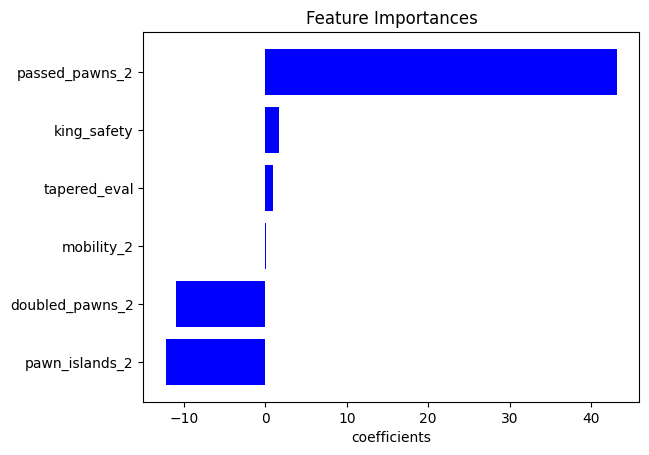

-12.211336047582556 pawn_islands_2
-10.989323012749525 doubled_pawns_2
0.11921912121128508 mobility_2
0.8957826182562153 tapered_eval
1.686172769493189 king_safety
43.17793328494146 passed_pawns_2


In [43]:
importances = lr_eval.coef_
indices = np.argsort(importances)

features = ['tapered_eval', 'king_safety', 'mobility_2', 'pawn_islands_2', 'doubled_pawns_2', 'passed_pawns_2']

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

In [44]:
def get_num_pieces(state):
        # get pawn counts
        wp = len(state.pieces(chess.PAWN, chess.WHITE))
        bp = len(state.pieces(chess.PAWN, chess.BLACK))
        
        # get knight counts
        wn = len(state.pieces(chess.KNIGHT, chess.WHITE))
        bn = len(state.pieces(chess.KNIGHT, chess.BLACK))

        # get bishop counts
        wb = len(state.pieces(chess.BISHOP, chess.WHITE))
        bb = len(state.pieces(chess.BISHOP, chess.BLACK))

        # get rook counts
        wr = len(state.pieces(chess.ROOK, chess.WHITE))
        br = len(state.pieces(chess.ROOK, chess.BLACK))

        # get queen counts
        wq = len(state.pieces(chess.QUEEN, chess.WHITE))
        bq = len(state.pieces(chess.QUEEN, chess.BLACK))
        
        return (
            (wp, P_PHASE), 
            (bp, P_PHASE), 
            (wn, N_PHASE), 
            (bn, N_PHASE), 
            (wb, B_PHASE), 
            (bb, B_PHASE), 
            (wr, R_PHASE), 
            (br, R_PHASE), 
            (wq, Q_PHASE), 
            (bq, Q_PHASE)
        )
    
def get_phase(state):
    phase = TOTAL_PHASE
    pieces = get_num_pieces(state)

    for num_pieces, phase_val in pieces:
        # more pieces = lower phase value
        # higher phase value = closer to endgame
        phase -= num_pieces * phase_val

    phase = (phase/TOTAL_PHASE) # scale with highest possible phase value
    return phase

def evaluate_piece(piece, square, phase):
    mg_score = 0
    eg_score = 0
    if piece.color == chess.WHITE:
        mg_score = MG_MAP[piece.piece_type][56 ^ square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][56 ^ square] + EG_VALUES[piece.piece_type]
    else:
        mg_score = MG_MAP[piece.piece_type][square] + MG_VALUES[piece.piece_type]
        eg_score = EG_MAP[piece.piece_type][square] + EG_VALUES[piece.piece_type]

    return mg_score * (1 - phase) + eg_score * (phase)

# return a static evaluation of the current position
def tapered_eval(state):
    
    outcome = state.outcome()
    if outcome is not None:
        if outcome.winner == chess.WHITE:
            return BASE_VALUES[chess.KING]
        elif outcome.winner == chess.BLACK:
            return -BASE_VALUES[chess.KING]
        else: # draw
            return 0 
    phase = get_phase(state)

    material_counts = {
        chess.WHITE : 0,
        chess.BLACK : 0
    }

    # python-chess defines A1 as 0, H8 as 63
    for square in range(64):
        piece = state.piece_at(square)
        if piece is None: # skip trying to evaluate empty squares
            continue
        piece_val = evaluate_piece(piece, square, phase)
        if piece.color == chess.WHITE:
            material_counts[chess.WHITE] += piece_val
        else:
            material_counts[chess.BLACK] += piece_val

    return material_counts[chess.WHITE] - material_counts[chess.BLACK]

In [45]:
# state is a ChessWrapper state
# TODO: check if this works for checked positions, checkmate positions, statemate positions

# return: white's mobility - black's mobility
def mobility(state):
    
    mobility1 = len(state.get_legal_moves())
    # Change side to move by pushing a null move and calculate all moves for opponent
    state.push(chess.Move.null())
    
    mobility2 = len(state.get_legal_moves())
    
    # Take back the null move to reset the board back to the position
    state.pop()

    # if turn is white, mobility 1 represents white's mobility
    mobility_delta = mobility1 - mobility2 
    if state.get_turn() == chess.BLACK:
        mobility_delta *= -1
    return mobility_delta

In [46]:
def doubled_pawns(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    rows = []
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        
        if row > 0:
            rows.append(row) # ignore the rows that are blank
            
    num_doubled = 0
    for i in range(len(rows) - 1):
        for j in range(i + 1, len(rows)):
            compared = rows[i] & rows[j]
            
            if (compared) > 0: # compare each pair of rows
                num_doubled += compared.bit_count() # if two rows have multiple pawns lined up
    return num_doubled

In [47]:
def pawn_islands(board, color):
    p_bb = int(board.pieces(chess.PAWN, color)) # get the pawn bitboard
    
    res = 0
    while p_bb > 0:
        row = p_bb & 0b11111111 # get bottom row       
        p_bb = p_bb >> 8 # remove bottom row
        res = res | row
    
    curr_run = 0
    islands = 0
    while res > 0:
        if res & 1 == 1:
            curr_run += 1
        else:
            if curr_run >= 1:
                islands += 1
                curr_run = 0
        res = res >> 1
    if curr_run >= 1:
        islands += 1
    return islands

In [48]:
def passers(board, color):
    p1_p_bb = int(board.pieces(chess.PAWN, color))
    p2_p_bb = int(board.pieces(chess.PAWN, not color))
    
    p1_rows = []
    p2_rows = []
    for i in range(8):
        row = p1_p_bb & 0b11111111 # get bottom row       
        p1_p_bb = p1_p_bb >> 8 # remove bottom row
        p1_rows.append(row)
        #print('{:08b}'.format(row))
        
    #print('------------')
    for i in range(8):
        row = p2_p_bb & 0b11111111 # get bottom row       
        p2_p_bb = p2_p_bb >> 8 # remove bottom row
        p2_rows.append(row)
        #print('{:08b}'.format(row))
        
    if color == chess.BLACK:
        p1_rows.reverse()
        p2_rows.reverse()
        
    passers = 0
    for r in range(1, 7):
        blockers = 0
        if p1_rows[r] > 0:
            for r2 in range(r + 1, 7):
                # for each row ahead of the p1's current row, check if there's a blocker
                blockers = blockers | p2_rows[r2] | (p2_rows[r2] << 1) | (p2_rows[r2] >> 1)
        passers += (~blockers & p1_rows[r]).bit_count()
    
    return passers

In [49]:
def king_safety(board, color):
    k = board.king(color) # get king's square
    kr = chess.square_rank(k) # get king's rank
    kf = chess.square_file(k) # get king's file
    
    
    king_zone = board.attacks(k)
    if color == chess.WHITE:
        delta = [(2, -1), (2, 0), (2, 1)]
    else:
        delta = [(-2, -1), (-2, 0), (-2, 1)]
        
    for d in delta:
        r = kr + d[0]
        f = kf + d[1]
        if r >= 0 and r <= 7 and f >= 0 and f <= 7:
            king_zone.add(chess.square(f, r))
    
    def_value = 0
    atk_value = 0
    # king zone defined as the squares the king can reach + 3 more forward squares facing enemy position
    for sq in king_zone:
        # get pieces attacking
        atks = board.attackers(not color, sq)
        # get pieces defending
        defs = board.attackers(color, sq)
                               
        for def_sq in defs:
            if board.piece_at(def_sq) is None:
                continue
            def_value += KZ_VALUES[board.piece_type_at(def_sq)]
        
        for atk_sq in atks:
            if board.piece_at(atk_sq) is None:
                continue
            atk_value += KZ_VALUES[board.piece_type_at(atk_sq)]
    return def_value, atk_value

In [50]:
def create_features(board):
    
    w_def, b_atk = king_safety(board, chess.WHITE)
    b_def, w_atk = king_safety(board, chess.BLACK)
    
    m = mobility(board)
    pi = pawn_islands(board, chess.WHITE) - pawn_islands(board, chess.BLACK)
    dp = doubled_pawns(board, chess.WHITE) - doubled_pawns(board, chess.BLACK)
    pp = passers(board, chess.WHITE) - passers(board, chess.BLACK)

    new_row = pd.DataFrame(
        {
            'tapered_eval': [tapered_eval(board)],
            'king_safety': [(w_def - b_atk) - (b_def - w_atk)],
            'mobility_2' : [np.square(m) * np.sign(m)],
            'pawn_islands_2' : [np.square(pi) * np.sign(pi)],
            'doubled_pawns_2' : [np.square(dp) * np.sign(dp)],
            'passed_pawns_2' : [np.square(pp) * np.sign(pp)],
        }
    )
    return new_row

In [51]:
def reg_eval(board):
    feat = create_features(board)
    return lr_eval.predict(feat)[0]

In [52]:
def qsearch(depth, board, alpha, beta, is_max, lin_reg_eval):
    if depth <= 0:
        return alpha if is_max else beta
    if lin_reg_eval:
        stand_pat = reg_eval(board)
    else:
        stand_pat = board.eval()
    if is_max:
        if stand_pat >= beta:
            return beta
        if stand_pat >= alpha:
            alpha = stand_pat
        moves = board.get_legal_moves()
        captures = [move for move in moves if board.is_capture(move)]
        ordered_captures = get_ordered_captures(board, captures)
        
        for move in ordered_captures:
            board.push(move)
            score = qsearch(depth - 1, board, alpha, beta, not is_max, lin_reg_eval)
            board.pop()
            if score >= beta:
                return beta # original: return score?
            if score > alpha:
                alpha = score
        return alpha
    else:
        if stand_pat <= alpha:
            return alpha
        if stand_pat <= beta:
            beta = stand_pat
        moves = board.get_legal_moves()
        captures = [move for move in moves if board.is_capture(move)]
        ordered_captures = get_ordered_captures(board, captures)
        
        for move in ordered_captures:
            board.push(move)
            score = qsearch(depth - 1, board, alpha, beta, not is_max, lin_reg_eval)
            board.pop()
            if score <= alpha:
                return alpha # original: return score?
            if score < beta:
                beta = score
        return beta

In [53]:
b = ChessWrapper()

In [54]:
alphabeta(4, b, float('-inf'), float('+inf'), True, True)

16.906209157876546

In [55]:
def find_best_move(board, depth, lin_reg_eval=True):
    is_max = (board.get_turn() == chess.WHITE)
    best_val = float('-inf') if is_max else float('+inf')

    if board.is_checkmate():
        return (None, -24000) if is_max else (None, 24000) # TODO: no magic variable pls

    # game is over but not checkmate, so it's a draw
    elif board.is_game_over():
        return (None, 0)
    
    moves = board.get_legal_moves()
    best_move = moves[0]
    for move in moves:
        board.push(move)
        move_val = alphabeta(depth - 1, board, float('-inf'), float('+inf'), not is_max, lin_reg_eval)
        board.pop()
        if is_max and move_val > best_val:
            best_move = move
            best_val = move_val
        elif not is_max and move_val < best_val:
            best_move = move
            best_val = move_val
    return best_move, best_val

In [56]:
find_best_move(b, 4)

(Move.from_uci('d2d4'), 16.906209157876546)

In [57]:
# wtm = True means alpha beta moves first, and is white
def vs_sf(elo=1400, depth=4, qdepth=6, wtm=True, fen=None):
    
    if fen is None:
        b = ChessWrapper()

        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_elo_rating(elo)
    else:
        b = ChessWrapper(fen)
        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_fen_position(fen)
        sf.set_elo_rating(elo)
    
    game = chess.pgn.Game()
    game.headers["Event"] = "sf elo: " + str(elo) + ', depth: ' + str(depth) + ', qdepth: ' + str(qdepth)
    
    if fen is not None:
        game.setup(fen)
        
    node = None

    while True:
        if b.is_game_over():
            break
        if wtm:
            m, v = find_best_move(b, depth, qdepth)
        else:
            m, v = chess.Move.from_uci(sf.get_best_move()), None

        b.push(m)
        sf.make_moves_from_current_position([str(m)])
        
        
        
        if node is None:
            node = game.add_variation(m)
        else:
            node = node.add_variation(m)
        
        if wtm:
            print('alpha-beta move')
        else:
            print('sf move')

        print(b)
        print('-' * 15)
        wtm = not wtm
    return b.outcome(), game

In [63]:
def est_elo(ab_depth=4, ab_qdepth=6):
    
    # sicilian (open), queen's indian, reti transposed to english
    openings = [
        'rnbqkb1r/pp2pppp/3p1n2/8/3NP3/8/PPP2PPP/RNBQKB1R w KQkq - 1 5',
        'rn1qkb1r/p1pp1ppp/bp2pn2/8/2PP4/5NP1/PP2PP1P/RNBQKB1R w KQkq - 1 5',
        'rnbqk2r/ppp1ppbp/3p1np1/8/2P1P3/2N2N2/PP1P1PPP/R1BQKB1R w KQkq - 0 5'
    ]
    
    random.shuffle(openings)
    
    lo = 1700
    hi = 2500
    
    df = pd.DataFrame(columns = ['depth', 'qdepth', 'lo', 'hi', 'elo', 'outcome', 'game'])
    
    for i in range(5):
        mid = (lo + hi) // 2
        ab_score = 0
        sf_score = 0
        
        # play 3 pairs
        for i in range(3):
            
            print('-' * 15)
            print(ab_depth, ab_qdepth, mid)
            # alpha beta plays white
            ab_white_oc, ab_white_game = vs_sf(elo=mid, depth=ab_depth, qdepth=ab_qdepth, wtm=True, fen=openings[i])
            
            if ab_white_oc.winner == chess.WHITE:
                ab_score += 1
            elif ab_white_oc.winner == chess.BLACK:
                sf_score += 1
            else:
                ab_score += 0.5
                sf_score += 0.5
                
            new_row = {'depth': ab_depth, 'qdepth': ab_qdepth, 'lo': lo, 'hi': hi, 'elo': mid, 'outcome': ab_white_oc.winner != chess.BLACK, 'game': ab_white_game}
            df = df._append(new_row, ignore_index=True)
            print(ab_white_oc)
            
            # if either player cuts off early, don't need to play the rest
            if ab_score >= 3.5 or sf_score >= 3.5:
                break
                
            print('-' * 15)
            print(ab_depth, ab_qdepth, mid)
                
            # alpha beta plays black
            ab_black_oc, ab_black_game = vs_sf(elo=mid, depth=ab_depth, qdepth=ab_qdepth, wtm=False, fen=openings[i])
            
            if ab_black_oc.winner == chess.BLACK:
                ab_score += 1
            elif ab_black_oc.winner == chess.WHITE:
                sf_score += 1
            else:
                ab_score += 0.5
                sf_score += 0.5
                
            new_row = {'depth': ab_depth, 'qdepth': ab_qdepth, 'lo': lo, 'hi': hi, 'elo': mid, 'outcome': ab_black_oc.winner != chess.WHITE, 'game': ab_black_game}
            df = df._append(new_row, ignore_index=True)
            print(ab_black_oc)
            
            # if either player cuts off early, don't need to play the rest
            if ab_score >= 3 or sf_score >= 3.5:
                break
                
        if ab_score >= 3:
            lo = mid
        else:
            hi = mid
            
    return df, lo, hi

In [ ]:
# fix q search depth, try alpha-beta depth 1, 2, 3, 4

df_results = pd.DataFrame(columns = ['depth', 'lo', 'hi'])
df_games = pd.DataFrame(columns = ['depth', 'qdepth', 'lo', 'hi', 'elo', 'outcome', 'game'])

for d in range(4, 5):
    df, lo, hi = est_elo(ab_depth=d, ab_qdepth=6)
    new_row = {'depth': d, 'lo': lo, 'hi': hi}
    df_results = df_results._append(new_row, ignore_index=True)
    df_games = pd.concat([df_games, df])
    print(df_results)
    print(df_games)

---------------
4 6 2100
alpha-beta move
r n b q k b . r
p p . . p p p p
. . . p . n . .
. B . . . . . .
. . . N P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
sf move
r n b q k b . r
p p . n p p p p
. . . p . . . .
. B . . . . . .
. . . N P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
alpha-beta move
r n b q k b . r
p p . n p p p p
. . . p . . . .
. B . . . N . .
. . . . P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
sf move
r n b q k b . r
. p . n p p p p
p . . p . . . .
. B . . . N . .
. . . . P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
alpha-beta move
r n b q k b . r
. p . n p p p p
p . . p . . . .
. . . . . N . .
B . . . P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
sf move
r n b q k b . r
. p . n p p . p
p . . p . . p .
. . . . . N . .
B . . . P . . .
. . . . . . . .
P P P . . P P P
R N B Q K . . R
---------------
alpha-beta move
r n b q k b . r
. p . n